- In this notebook, I show the performance of RNet and generated the input data of ONet  
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## The RNet Box
- Given the image, and the bounding boxes generated from the **pnet box**, it generates the image boxes with the size of 24

- Then, it puts these image boxes into RNet to get prediction boxes, converts the boxes into squares and calibrates them according to the offset values.

- After that, it chooses the boxes that might have face (larger than **MIN_FACE_SIZE**) based on the **THRESHOLDS** and deletes the repetitive boxes based on the **NMS_THRESHOLDS**  
- Finally, it returns the bounding box information to show the images.

In [5]:
def rnet_boxes(img, rnet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS, show_boxes=True):
    rnet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=24)
    try:
        img_boxes = torch.FloatTensor(img_boxes)
        img_boxes=img_boxes.cuda()
        output = rnet(img_boxes)
        probs = output[0].data.cpu().numpy()  # shape [n_boxes, 1]
        offsets = output[1].data.cpu().numpy()  # shape [n_boxes, 4]

        keep = np.where(probs[:, 0] > thresholds[1])[0]
        bounding_boxes = bounding_boxes[keep]
        bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
        offsets = offsets[keep]

        keep = nms(bounding_boxes, nms_thresholds[1])
        bounding_boxes = bounding_boxes[keep]
        bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
        bounding_boxes = convert_to_square(bounding_boxes)
        bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
        if show_boxes: show_bboxes(img, bounding_boxes, []).show()
        return bounding_boxes
    except:
        return None

## Show the Boxes

#### Set the parameters

In [10]:
landmark_data_dir = '../input/facial-point-detection/Facial_Point_Detection'
landmark_train_txt_path = '../input/facial-point-detection/Facial_Point_Detection/trainImageList.txt'
landmark_eval_txt_path = '../input/facial-point-detection/Facial_Point_Detection/testImageList.txt'
pnet_weight_path='../input/landmark/ldmk-pnet_10000_30 best.pkl'
rnet_weight_path='../input/landmark/ldmk-rnet_9996_60.pkl'
train_num=None
eval_num=None
class_data_augment = 3 
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()
rnet=R_Net().cuda()
rnet.load_state_dict(torch.load(rnet_weight_path))
rnet.eval()


R_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
    (7): PReLU(num_parameters=1)
  )
  (conv4): Linear(in_features=256, out_features=128, bias=True)
  (prelu4): PReLU(num_parameters=1)
  (conv5_1): Linear(in_features=128, out_features=1, bias=True)
  (conv5_2): Linear(in_features=128, out_features=4, bias=True)
  (conv5_3): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
def show_boxes(img, bounding_boxes):
    plt.imshow(img)
    for b in bounding_boxes:
        plt.gca().add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=1))
    plt.show()

#### Show sample images from the training set

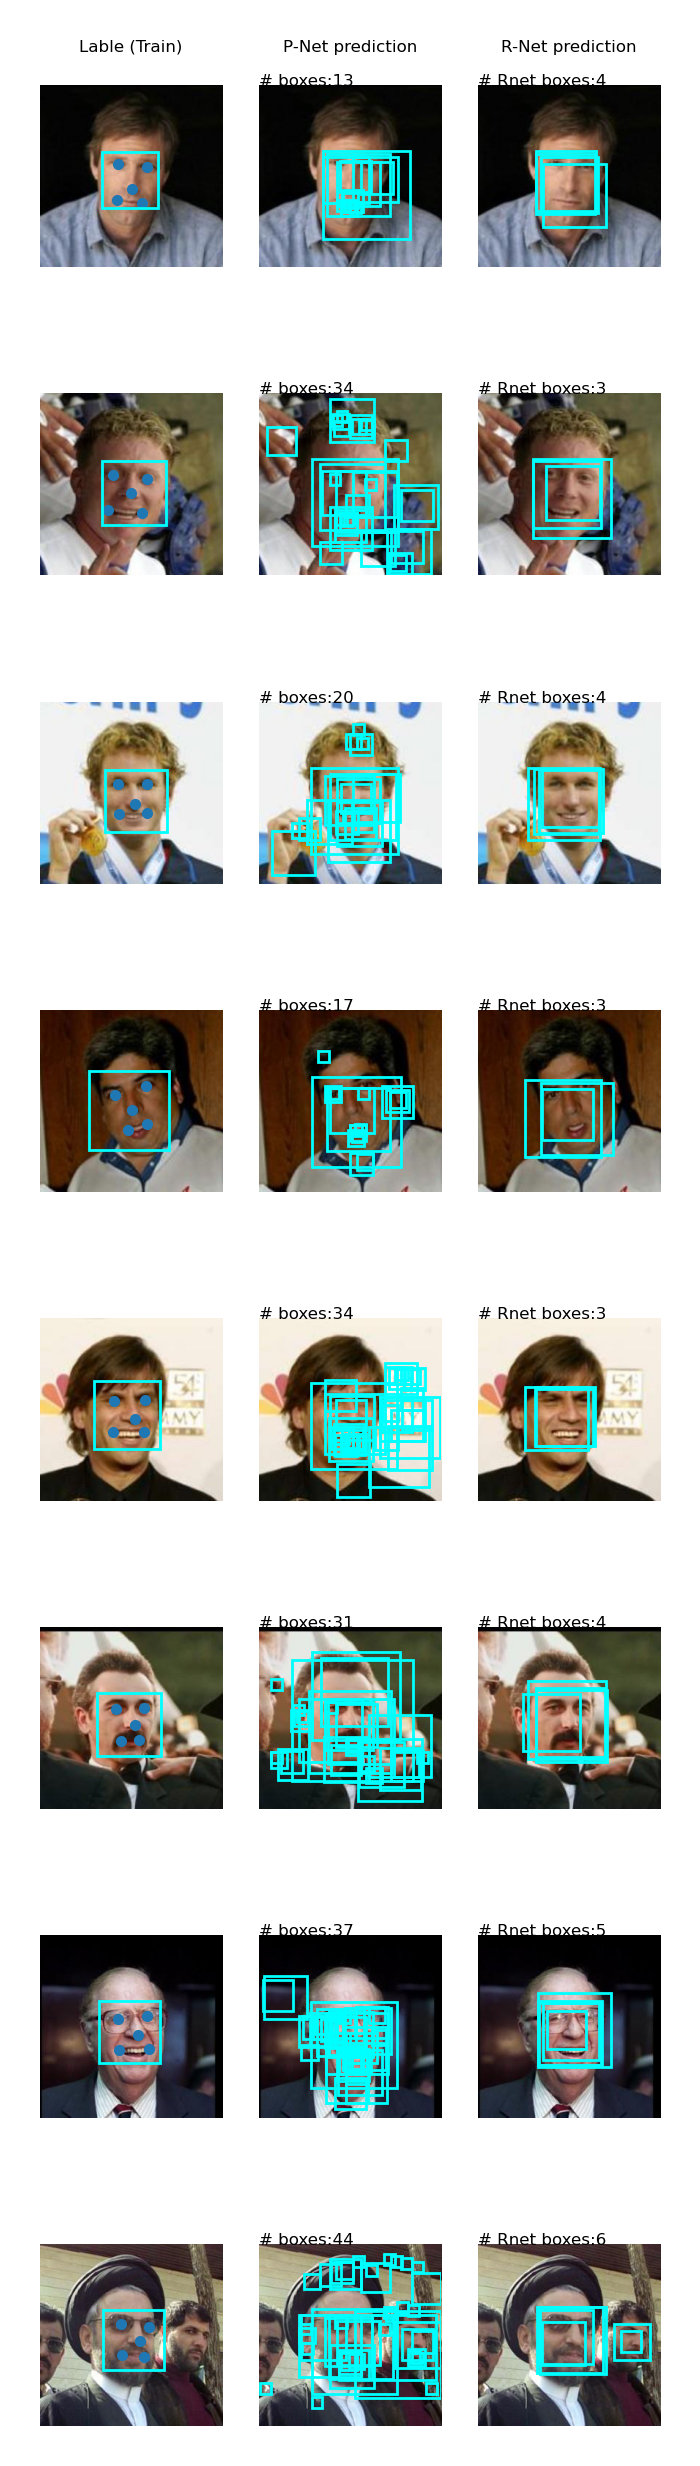

In [12]:
# get 8 fixed images
data_for_demo = landmark_dataset_txt_parser(landmark_train_txt_path, landmark_data_dir,num_data=8)
# box: (x1,x2,y1,y2)
# landmark: (x1,y1,x2,y2,x3,y3...)
# demo and plot
fig, ax = plt.subplots(8,3,dpi = 400, figsize=(2,8))

for i in range(len(data_for_demo)):
    img_pth, gts,p = data_for_demo[i]
    gts=np.array(gts)
    if gts.ndim is 1:
        gts = np.expand_dims(gts, 0)
        gts[:, :] = gts[:, (0, 2, 1, 3)]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    
    ax[i,0].imshow(img)
    ax[i,0].scatter([p[j*2] for j in range(5)],[p[j*2+1] for j in range(5)],s=1)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable (Train)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
fig.show()
fig.savefig('Rnet train.png')

#### Show sample images from the eval set

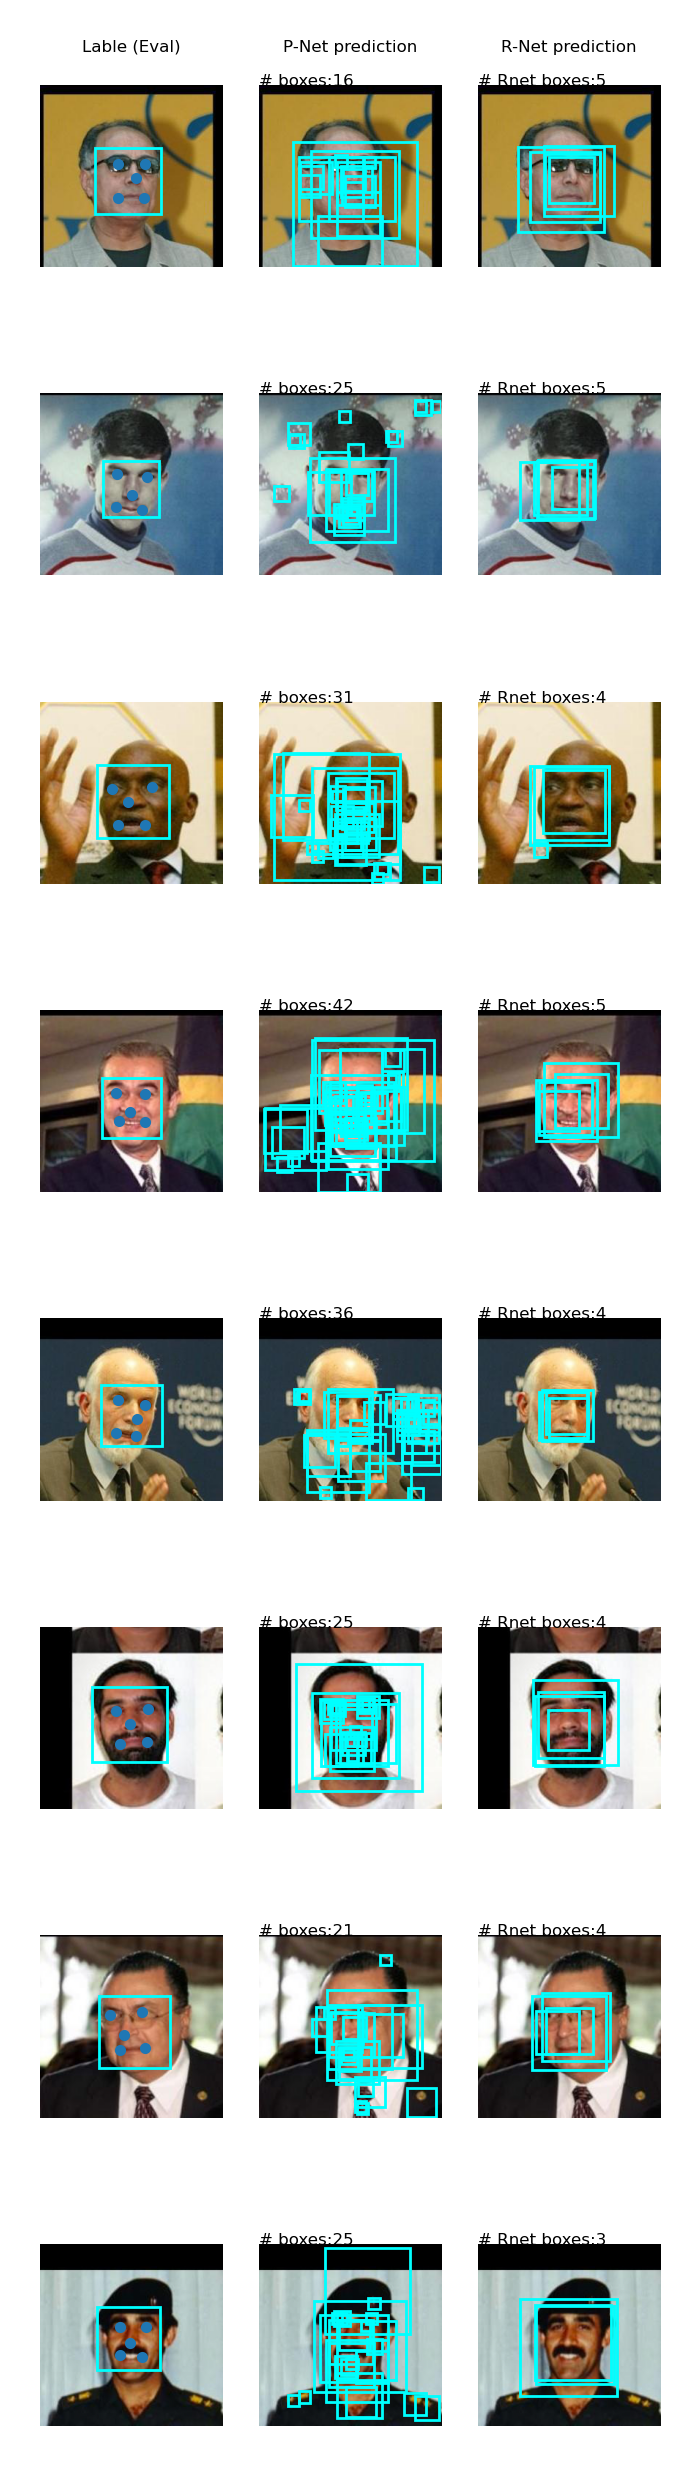

In [13]:
# get 8 fixed images
data_for_demo = landmark_dataset_txt_parser(landmark_eval_txt_path, landmark_data_dir,num_data=8)
# box: (x1,x2,y1,y2)
# landmark: (x1,y1,x2,y2,x3,y3...)
# demo and plot
fig, ax = plt.subplots(8,3,dpi = 400, figsize=(2,8))

for i in range(len(data_for_demo)):
    img_pth, gts,p = data_for_demo[i]
    gts=np.array(gts)
    if gts.ndim is 1:
        gts = np.expand_dims(gts, 0)
        gts[:, :] = gts[:, (0, 2, 1, 3)]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    
    ax[i,0].imshow(img)
    ax[i,0].scatter([p[j*2] for j in range(5)],[p[j*2+1] for j in range(5)],s=1)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable (Eval)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
fig.show()
fig.savefig('Rnet eval.png')

## Generate the Input Data for ONet  
- In this part, it puts the images into the PNet and RNet to get the prediction boxes and save the crop information and the name of the coresponding images in a txt file.

- The output txt file should have lines in this format:
      image_path *gt_x1, gt_y1, gt_x2, gt_y2* Lx1,Ly1,Lx2,Ly2,Lx3,Ly4,Lx5,Ly5*label cr_x1, cr_y1, cr_x2, cr_y2 + ... + label, cr_x1, cr_y1, cr_x2, cr_y2 * \n
  Here is an example:
      ../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Ali_Khamenei_0001.jpg*71,85,178,192*107,111,150,107,125,136,113,152,148,151*pf,96,98,185,186+pf,74,93,195,215
      
- If there is no prediction box, it will print:
         "Wrong: (None, None, None)"

In [14]:
landmark_train=landmark_dataset_txt_parser(landmark_train_txt_path, landmark_data_dir,num_data=train_num)
landmark_eval=landmark_dataset_txt_parser(landmark_eval_txt_path, landmark_data_dir,num_data=eval_num)

In [16]:
onet_train_data=open('ldmk_onet_train_data.txt', 'w')
print('Train Begin')
for index in range(len(landmark_train)):
    
    if index%500==0:
        print(index)
    img, faces,ldmk=get_size_faces_ldmk(landmark_train, index)
    label_boxes=get_crop_img_label_box(img ,faces,pnet,rnet)
    img_path=landmark_train[index][0]
    try:
        boxes='+'.join([w[0]+','+','.join(w[1]) for w in label_boxes])
        faces=','.join([str(i) for i in faces[0]])
        if ldmk is not None:
            ldmk=','.join([str(i) for i in ldmk])
        else:
            print(img_path,'no ldmk')
        onet_train_data.write(img_path+'*'+faces+'*'+ldmk+'*'+boxes+'\n')
        if index <=3:
            print(img_path+'*'+faces+'*'+ldmk+'*'+boxes+'\n')
    except:
        print('Wrong:',label_boxes)
onet_train_data.close()   
print('Train End')

print('Eval Begin')
onet_eval_data=open('ldmk_onet_eval_data.txt', 'w')
for index in range(len(landmark_eval)):
    if index%500==0:
        print(index)
    img, faces,ldmk=get_size_faces_ldmk(landmark_eval, index)
    label_boxes=get_crop_img_label_box(img ,faces,pnet,rnet)
    img_path=landmark_eval[index][0]
    try:
        boxes='+'.join([w[0]+','+','.join(w[1]) for w in label_boxes])
        faces=','.join([str(i) for i in faces[0]])
        if ldmk is not None:
            ldmk=','.join([str(i) for i in ldmk])
        else:
            print(img_path,'no ldmk')
        onet_eval_data.write(img_path+'*'+faces+'*'+ldmk+'*'+boxes+'\n')
        if index <=3:
            print(img_path+'*'+faces+'*'+ldmk+'*'+boxes+'\n')
    except:
        print('Wrong:',label_boxes)
onet_train_data.close()   
print('Eval End')

Train Begin
0
../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Aaron_Eckhart_0001.jpg*84,92,161,169*106,107,146,112,125,142,105,157,139,161*pf,84,92,161,169+pf,84,92,161,169+p,84,92,161,169+n,84,92,161,169+p,84,92,161,169+pf,84,92,161,169+p,84,92,161,169+p,84,92,161,169

../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Aaron_Guiel_0001.jpg*85,93,172,181*100,111,145,116,124,136,92,159,138,163*pf,85,93,172,181+p,85,93,172,181+pf,85,93,172,181+pf,85,93,172,181+n,85,93,172,181+n,85,93,172,181+n,85,93,172,181+n,85,93,172,181+p,85,93,172,181+p,85,93,172,181+p,85,93,172,181

../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Aaron_Peirsol_0001.jpg*88,94,173,179*106,113,146,113,129,139,108,153,146,152*p,88,94,173,179+pf,88,94,173,179+pf,88,94,173,179+pf,88,94,173,179+n,88,94,173,179+n,88,94,173,179+p,88,94,173,179+p,88,94,173,179+p,88,94,173,179+p,88,94,173,179

../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Aaron_Pena_0001.jpg*67,83,